# Brief Description of the Problem and Data

The Challenge Problem: 
The goal of the Kaggle competition titled "Monet Painting Dataset (New)" is to build generative models, specifically Generative Adversarial Networks (GANs), to create new images that mimic the style of the French impressionist painter Claude Monet. Participants are tasked with generating images that could plausibly pass as Monet's work, using a dataset of his paintings. The challenge is to capture the essence of Monet's style, such as his unique color palettes, brushstrokes, and composition.


Amy Jang, Ana Sofia Uzsoy, Phil Culliton. (2020). I’m Something of a Painter Myself. Kaggle. https://kaggle.com/competitions/gan-getting-started

Generative Deep Learning Models:
Generative models are a class of artificial intelligence algorithms used in unsupervised learning. They are designed to learn the patterns and distribution of input data so that they can generate new data points that resemble the original dataset. GANs, which are a subset of generative models, consist of two neural networks that contest with each other in a game (hence "adversarial"). The generator network generates new data instances, while the discriminator network evaluates them against a set of real data instances. The goal is to train the generator to produce data indistinguishable from actual data, fooling the discriminator.

### Dataset Description

The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The monet_tfrec and monet_jpg directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Check out the CycleGAN dataset to experiment with the artistic style of other artists.

#### Files
* `monet_jpg` - 300 Monet paintings sized 256x256 in JPEG format
* `monet_tfrec` - 300 Monet paintings sized 256x256 in TFRecord format
* `photo_jpg` - 7028 photos sized 256x256 in JPEG format
* `photo_tfrec` - 7028 photos sized 256x256 in TFRecord format

#### Submission format
Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import time
import shutil

from PIL import Image

from pathlib import Path

from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

from IPython import display

In [3]:
def show_folder_info(path):
    d_image_sizes = {}
    for image_name in os.listdir(path):
        image = cv2.imread(os.path.join(path, image_name))
        if image is not None:
            d_image_sizes[image.shape] = d_image_sizes.get(image.shape, 0) + 1
        else:
            print(f"Error reading image: {image_name}")
            
    for size, count in d_image_sizes.items():
        print(f'shape: {size}\tcount: {count}')

def get_image_info(directory):
    image_info = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        with Image.open(img_path) as img:
            img_info = {
                'Filename': img_name,
                'Width': img.width,
                'Height': img.height,
                'Mode': img.mode
            }
            image_info.append(img_info)
    return image_info

monet_jpg_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_jpg_dir = '/kaggle/input/gan-getting-started/photo_jpg' 

print('Monet images:')
show_folder_info(monet_jpg_dir)

print('Photo images:')
show_folder_info(photo_jpg_dir)

monet_image_info = get_image_info(monet_jpg_dir)
photo_jpg_info = get_image_info(photo_jpg_dir)

print(monet_image_info[:5])
print(photo_jpg_info[:5])

Monet images:
shape: (256, 256, 3)	count: 300
Photo images:
shape: (256, 256, 3)	count: 7038
[{'Filename': 'f4413e97bd.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '7341d96c1d.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': 'de6f71b00f.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '99d94af5dd.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '99a51d3e25.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}]
[{'Filename': 'fb97febc5f.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': 'c54c5368af.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '4a06596662.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '2629524a69.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}, {'Filename': '5e64b64de8.jpg', 'Width': 256, 'Height': 256, 'Mode': 'RGB'}]


* Monet Images:
    * All the Monet images have a uniform shape of 256x256 pixels with 3 color channels (RGB).
    * There are a total of 300 Monet images in the dataset.


* Photo Images:
    * All the photo images are also 256x256 pixels with 3 color channels (RGB).
    * There are 7038  photo images.


* Images:
    * The filenames are alphanumeric with the .jpg extension.
    * All are in RGB color mode and have the dimensions of 256x256 pixels.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

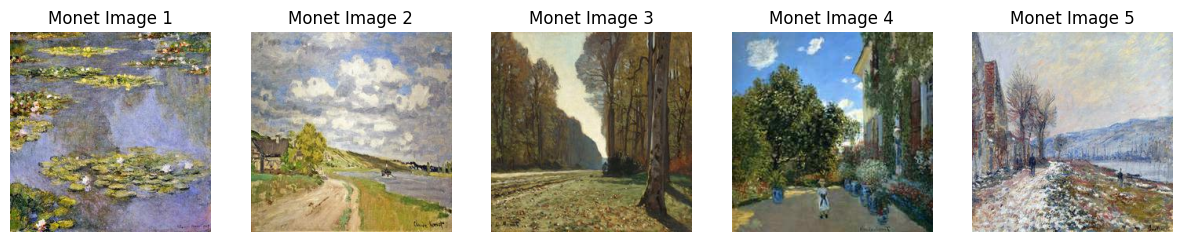

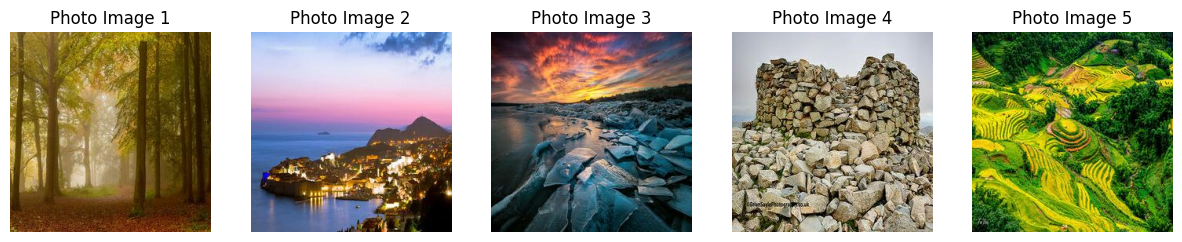

In [4]:
monet_path = Path('/kaggle/input/gan-getting-started/monet_jpg')
photo_path = Path('/kaggle/input/gan-getting-started/photo_jpg')

def display_images(image_paths, title):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.show()

sample_monet_images = list(monet_path.glob('*.jpg'))[:5]
sample_photo_images = list(photo_path.glob('*.jpg'))[:5]

display_images(sample_monet_images, "Monet Image")
display_images(sample_photo_images, "Photo Image")

Monet Paintings:
- The collection of Monet paintings exhibits a diverse range of color palettes and brushstroke techniques, characteristic of his impressionist style, which I referenced through online research.
- These paintings predominantly depict natural landscapes, emphasizing the interplay of light and reflections, which are recurring themes in Monet's artistic repertoire.

Photo Images:
- The assortment of photographs showcases various subjects and settings, offering a wide array of visual content.
- Notably, the photographs exhibit more vivid colors and sharper lines compared to Monet's paintings, aligning with the typical traits of photos versus impressionist artworks.
- While some images are distinctly identifiable as not being Monet's paintings (e.g., Image 4), distinguishing others might pose a challenge (e.g., Image 1).

Moving forward, our analysis will delve into the color distributions of these images. This will involve plotting color histograms for a selection of images from both the Monet painting and photograph categories. Color histograms provide insights into the frequency of different color intensities present within an image. Examining these histograms will enable us to discern prevalent color profiles in Monet's paintings as opposed to photographs, offering valuable guidance in designing the generator network of the GAN (Generative Adversarial Network) to replicate Monet's distinctive artistic style.

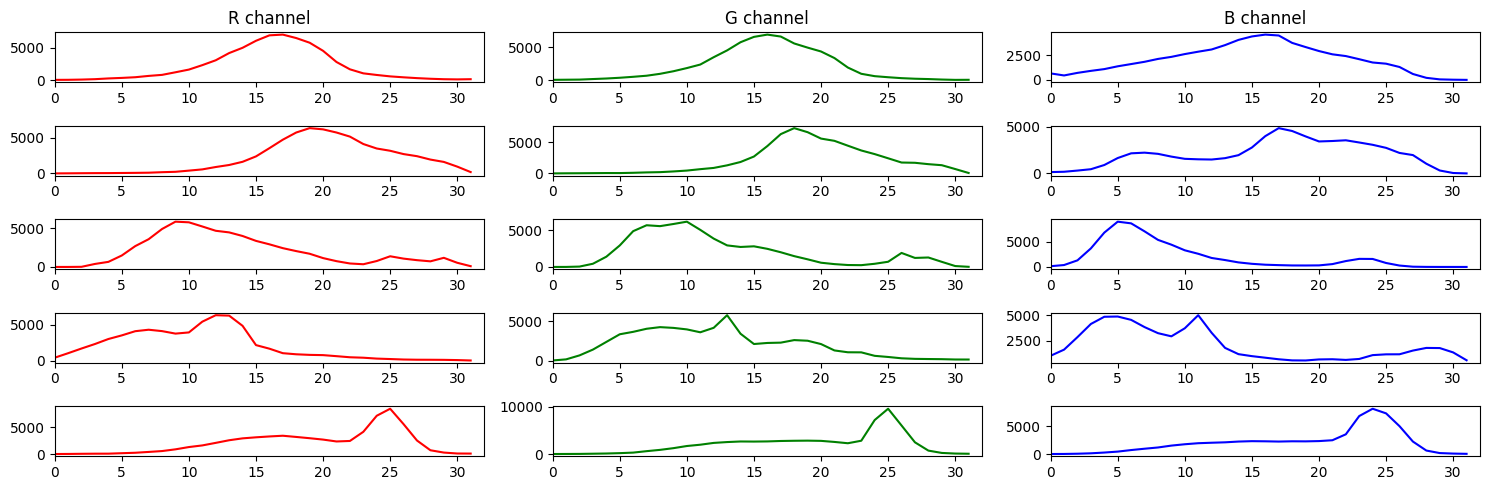

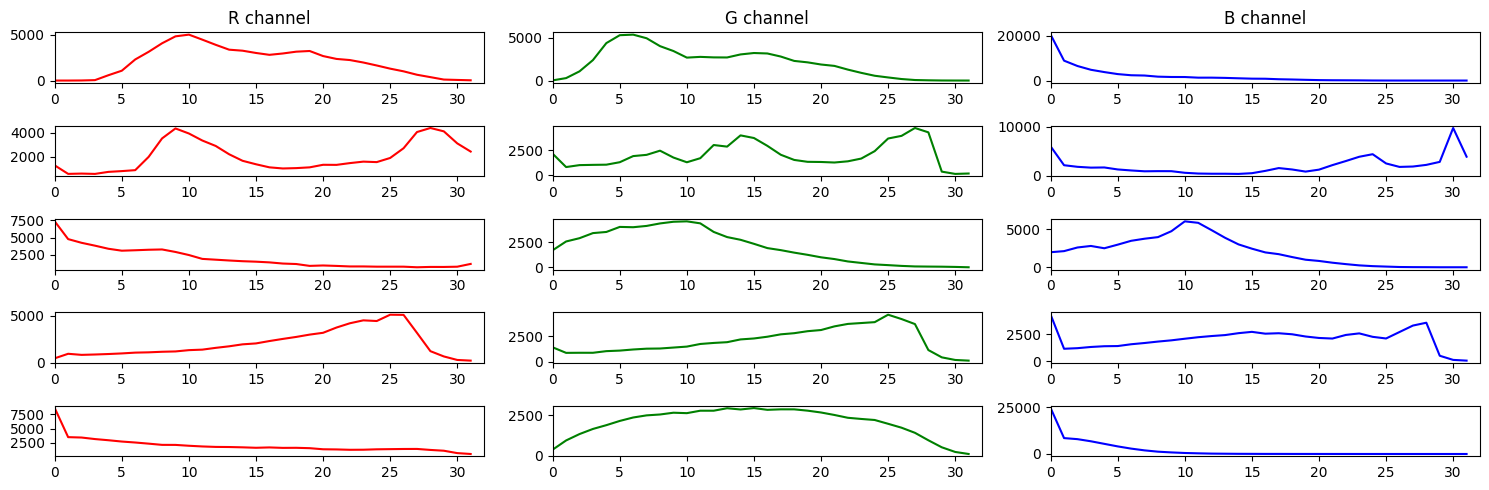

In [5]:
def plot_color_histograms(image_paths, title):
    plt.figure(figsize=(15, 5))
    
    bins = 32
    
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(str(image_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        color = ('r', 'g', 'b')
        for j, col in enumerate(color):
            histr = cv2.calcHist([img], [j], None, [bins], [0, 256])
            plt.subplot(len(image_paths), 3, i * 3 + j + 1)
            plt.plot(histr, color=col)
            plt.xlim([0, bins])
            if i == 0:
                plt.title(f'{col.upper()} channel')
        
        plt.tight_layout()

plot_color_histograms(sample_monet_images, "Monet Image Histogram")
plot_color_histograms(sample_photo_images, "Photo Image Histogram")

The histograms displayed above represent the color distributions observed in both Monet's paintings and photo images.

Monet Images Histograms:
- The histograms of the R (Red) channel tend to exhibit broader distributions, suggesting a wider array of red tones prevalent in these images.
- G (Green) channel histograms appear relatively flatter, implying a more consistent spread of green tones across the Monet paintings.
- B (Blue) channel histograms exhibit peaks at various levels, likely corresponding to notable blue elements in Monet's artworks, such as the sky or water.

These color intensities align well with Monet's characteristic palette, particularly the prevalence of blues and greens evident in his renowned water lilies and garden scenes. The histograms also exhibit more blending and wider distributions, typical of the mixed brushstrokes found in paintings.

Photo Images Histograms:
- R channel histograms demonstrate distinct peaks, potentially indicating specific objects or features with pronounced red colors.
- G channel histograms display less variability, with certain images showcasing a more concentrated distribution of green tones.
- B channel histograms demonstrate variability, with certain images showcasing a strong presence of blue, likely representing scenes containing significant sky or water elements.

The histograms for the photo images generally reveal sharper peaks and potentially a more diverse color distribution, reflecting the vivid and diverse color schemes captured by modern camera devices.
Specific colors may dominate based on the scene captured, such as the pronounced red and orange tones seen in the photograph depicting a sunset sky.

In summary, when compared to the photo images, the Monet histograms exhibit more blending and less defined peaks, indicating the softer transitions and brushwork characteristic of impressionist paintings. Conversely, the histograms for the photo images portray sharper peaks and valleys, signifying the more defined and focused content typical of photographic images.

# Model Architecture

In the preprocessing phase, the image handling involves several steps. Firstly, we access the images from TFRecord files, perform normalization, resize the images, and apply transformations for data augmentation. Finally, the datasets are batched and prefetched to streamline the training process.

Normalization:
- The normalization is necessary as the generator's output layer typically utilizes the tanh activation function, which generates values within a specific range.
- Reshaping: Images are reshaped to guarantee the correct dimensions after the decoding process.

Augmentation:
- Random Jittering and Cropping: The images undergo resizing to 286x286 dimensions and are then randomly cropped back to 256×256.
- Random Rotation: Images are subject to random rotation across various degrees as part of the augmentation process.

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    # If TPU is detected, use the GCS path
    GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
except ValueError:
    # If no TPU is detected, use the local path
    GCS_PATH = '/kaggle/input/gan-getting-started/'

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# normalise
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [IMG_HEIGHT, IMG_WIDTH, 3])
    return image

# read TFRecord
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# augment
def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

monet_ds = load_dataset(MONET_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = load_dataset(PHOTO_FILENAMES).map(data_augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

Displaying Monet images:


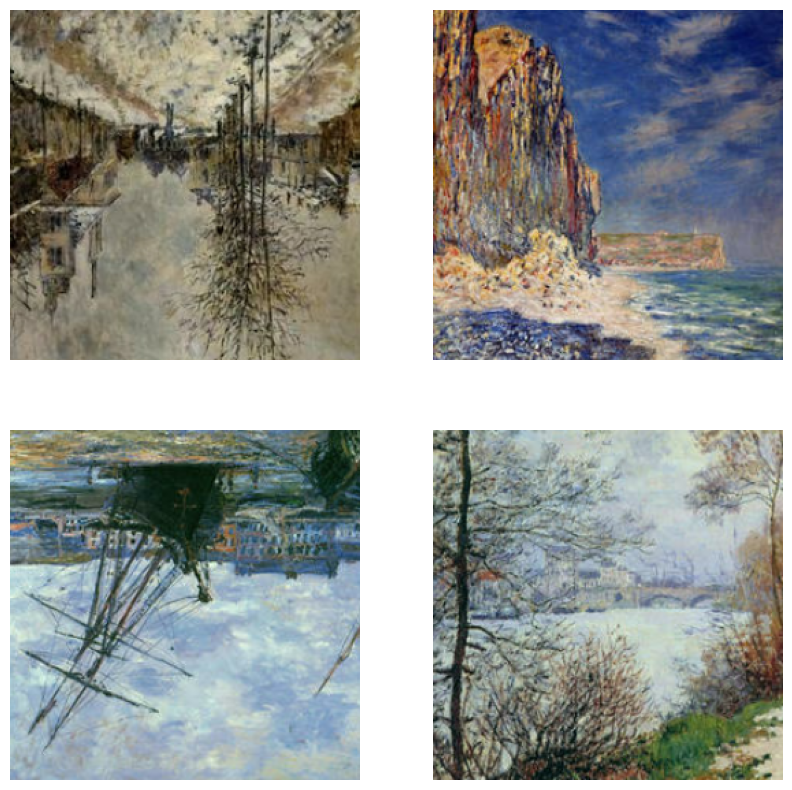

Displaying Photo images:


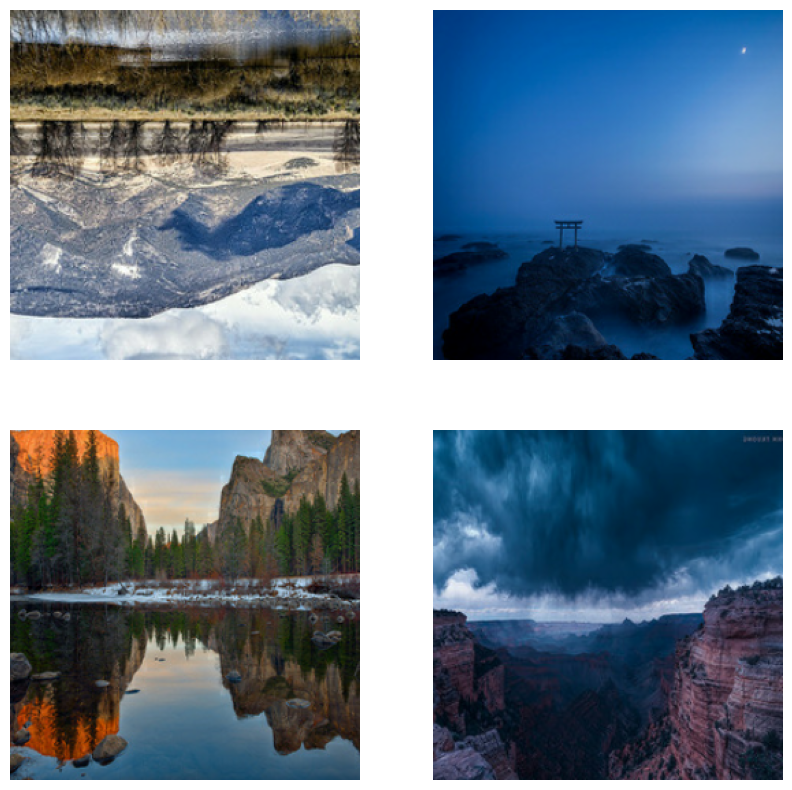

In [8]:
# check that it works 

def show_batch(dataset):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(BATCH_SIZE):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow((images[i].numpy() + 1) / 2)
            plt.axis("off")
    plt.show()

print("Displaying Monet images:")
show_batch(monet_ds)

print("Displaying Photo images:")
show_batch(photo_ds)

Here's a detailed breakdown of the Deep Convolutional Generative Adversarial Network (DCGAN) architecture used for this image generation task:

### Generator Architecture:

- **Input Layer:**
  - The generator begins with a dense layer that takes a noise vector (latent dimension) as input. This vector is randomly generated and serves as the foundation for image generation.

- **Upscaling Layers:**
  - The output of the dense layer is reshaped to form the initial "image" structure.
  - Subsequent transposed convolutional layers (Conv2DTranspose) are applied to gradually upscale the image to a higher resolution. Each layer increases the spatial dimensions (height and width) of the output.

- **Batch Normalization:**
  - Batch normalization is performed after each transposed convolutional layer. It stabilizes and normalizes the inputs to the following layer, aiding in training deep networks.

- **Activation Functions:**
  - LeakyReLU activation functions are utilized for intermediate layers. This activation function allows a small gradient when the unit is not active, facilitating better gradient flow through the architecture.

- **Output Layer:**
  - The final layer employs a tanh activation function. This layer produces the generated image with pixel values normalized between -1 and 1.

### Discriminator Architecture:

- **Input Layer:**
  - The discriminator takes an image (either real or generated by the generator) as input.

- **Downscaling Layers:**
  - Series of convolutional layers (Conv2D) progressively downscale the image by reducing its spatial dimensions while increasing the depth (number of filters).

- **Activation Functions:**
  - LeakyReLU activation functions are used in the discriminator, allowing the network to learn non-linear decision boundaries.

- **Dropout Layers:**
  - Dropout layers are incorporated to mitigate overfitting by randomly setting a fraction of input units to zero during training.

- **Output Layer:**
  - The network culminates in a dense layer that outputs a single value. This value represents the discriminator's evaluation of whether the input image is real or fake.

In [9]:
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[256, 256, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

Here's an explanation of the loss functions utilized for training the Generative Adversarial Network (GAN):

### Binary Cross-Entropy Loss:
- **Rationale:** Binary cross-entropy is chosen as the loss function due to its suitability for binary classification tasks, which aligns with the discriminator's role in classifying images as real or fake.

### Discriminator Loss:
- **Components:**
  - `real_loss`: Measures how accurately the discriminator classifies real images as real. It compares the discriminator's predictions on real images (`real_output`) against an array of 1s (since real images should be classified as 1).
  - `fake_loss`: Measures how accurately the discriminator classifies fake images as fake. It compares the discriminator's predictions on fake images (`fake_output`) against an array of 0s.
- **Total Discriminator Loss:** 
  - The total discriminator loss is the sum of `real_loss` and `fake_loss`.

### Generator Loss:
- **Objective:** The generator aims to deceive the discriminator by producing images that are indistinguishable from real ones.
- **Loss Calculation:** It compares the discriminator's predictions on the fake images against an array of 1s. The generator loss measures how effectively the generator fools the discriminator into believing that the generated images are real.

### Summary:
- **Discriminator Loss:** Ensures the discriminator correctly classifies real and fake images.
- **Generator Loss:** Encourages the generator to produce images that deceive the discriminator.
- **Training Dynamics:** These loss functions create a feedback loop where the generator and discriminator continuously improve in tandem: the generator learns to create more realistic images, challenging the discriminator, which in turn becomes better at distinguishing real from fake. This simultaneous training process enhances both the generator's and discriminator's capabilities.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Following this, we'll set up individual optimizers for both the generator and the discriminator.

To facilitate this, we'll employ the Adam Optimizer, a blend of two stochastic gradient descent extensions, namely, the Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp).
- We'll adopt a relatively low learning rate to ensure a consistent and steady training process.
- Additionally, we'll incorporate an exponential decay rate by setting beta_1 = 0.5, allowing for dynamic adjustments to the learning rate as the training progresses.

In [11]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

Subsequently, we'll establish the training loop for the GAN, continually refining both the generator and the discriminator.

* We define a function named 'train_step' responsible for executing a single training iteration for both the generator and discriminator, utilizing a random noise vector.
* Employing 'gradienttape' enables us to trace the operations, crucial for automatic differentiation.
* During training, the generator generates images from noise, while the discriminator discerns these images.
* We compute the losses and compute gradients of these losses concerning model weights, then adjust the weights based on these calculated gradients.
* This iterative process traverses through batches for each epoch, sequentially updating the generator and discriminator.
* Simultaneously, we visualize the ongoing progress, including the losses incurred by the generator and discriminator, along with the training duration per epoch.

In [12]:
EPOCHS = 50

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    epoch_times = []

    for epoch in range(epochs):
        start_time = time.time()
        gen_loss_epoch = []
        disc_loss_epoch = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch.append(gen_loss)
            disc_loss_epoch.append(disc_loss)

        gen_losses.append(np.mean(gen_loss_epoch))
        disc_losses.append(np.mean(disc_loss_epoch))
        epoch_duration = time.time() - start_time
        epoch_times.append(epoch_duration)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, epoch_duration))

    return gen_losses, disc_losses, epoch_times

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

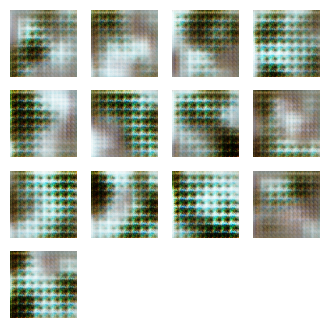

Time for epoch 48 is 58.02752351760864 sec


In [ ]:
num_examples_to_generate = 13
seed = tf.random.normal([num_examples_to_generate, latent_dim])

gen_losses, disc_losses, epoch_times = train(monet_ds, EPOCHS)

# Results and Analysis

In [ ]:
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs_range, gen_losses, label='Generator Loss')
plt.plot(epochs_range, disc_losses, label='Discriminator Loss')
plt.title('Generator and Discriminator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, epoch_times, label='Training Time per Epoch', color='orange')
plt.title('Training Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

GAN Training Losses:

In the upper chart, the generator and discriminator losses are illustrated across epochs. Both losses begin at distinct values, initially with the generator loss being notably higher. Over time, both losses gradually decrease, indicating the learning progress of both networks (generator and discriminator). The generator's loss undergoes a sharp initial decrease, a common behavior as it starts learning from a less informed state. However, it's crucial to note that the generator's loss shouldn't plummet to zero, as it would imply overly effortless deception of the discriminator, impacting the model's ability to produce diverse outputs. Concurrently, the discriminator's loss also decreases, albeit at a slower pace. This could suggest an enhancement in its ability to differentiate between real and generated images. Ideally, the discriminator's loss should maintain a balance, neither excessively high nor extremely low, signifying an equilibrium in the competition between the generator and discriminator.

Training Duration per Epoch:

In the lower chart, the duration of training per epoch is depicted in seconds. An initial spike may indicate some preliminary setup or caching effects. However, the overall trend shows a slight decrease or stabilization in the time taken per epoch as training progresses.

Hyperparameter Optimization:

* Manual Tuning Method:
    * Due to limitations in resources and time, an automated hyperparameter optimization method was not employed.
    * Emphasis was placed on manually fine-tuning the learning rate and beta values within the Adam optimizer.

* Chosen Hyperparameters:
    * Learning Rate: Initially experimented with 0.01, but settled on 0.0002 as it proved more effective. This lower rate is a commonly stable starting point for GAN training. Attempts at increasing the rate resulted in unstable training with no convergence.
    * Optimizer's Beta Values: Maintained a beta value of 0.5 throughout, as it aids in adapting the learning rate based on a shorter gradient history. This adjustment is valuable in the volatile GAN training environment.
    * Batch Size Testing: Various batch sizes were tested. Smaller batches added more noise, and larger ones didn't enhance performance significantly.
    * Exploration of Latent Dimension Size: Experimented with different sizes for the latent dimension vector. Extremely large or small sizes did not capture the data complexity adequately or significantly increased computational demand without notable benefits.

* Alternative Loss Functions and Optimizers:
    * AdaGrad Trials: AdaGrad was explored as an alternative to Adam. AdaGrad adapts the learning rate to parameters, applying larger updates to infrequent parameters and smaller ones to frequent ones.
    * However, AdaGrad didn’t yield significant improvements over Adam. This outcome was particularly influenced by the dense nature of the image data, which is better suited for Adam optimization.
    * Retained Adam due to its adaptability and consistent performance in GAN training.

Note: Other models were run separately but not included in the notebook due to kernel size constraints.

In [ ]:
num_images_to_generate = 7000

output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

for i in range(num_images_to_generate):
    noise = tf.random.normal([1, latent_dim])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image + 1.0) * 127.5
    generated_image = tf.cast(generated_image, tf.uint8)
    tf.keras.preprocessing.image.save_img(
        os.path.join(output_dir, f'image_{i}.jpg'),
        generated_image[0],
        data_format='channels_last'
    )

print(f'{num_images_to_generate} images generated and saved to {output_dir}')

In [ ]:
shutil.make_archive('images', 'zip', 'generated_images')

In [ ]:
output_dir = '/kaggle/working/generated_images'
zip_file = '/kaggle/working/images.zip'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

for filename in os.listdir('/kaggle/working'):
    file_path = os.path.join('/kaggle/working', filename)
    if os.path.isfile(file_path) and filename != 'images.zip':
        os.remove(file_path)

**Objective and Approach:**

The objective of this project was to train a Generative Adversarial Network (GAN) to replicate the artistic style of Claude Monet's paintings. However, this task was challenging as it involved complex steps, especially because the project required steps not covered in our learning modules. The process began with image preprocessing, where the pixel values were normalized, and data augmentation was applied to diversify the training dataset. The architecture involved a Deep Convolutional GAN (DCGAN) with a generator creating images from noise and a discriminator distinguishing between real and generated images. The models were trained using binary cross-entropy loss and the Adam optimizer with carefully selected hyperparameters. The prolonged training time made it imperative to ensure each step was executed accurately and precisely.

**Key Learnings:**

Several significant takeaways emerged from this project. Firstly, the choice of normalization techniques and data augmentation significantly impacted training stability and the quality of the generated images. Secondly, the manual tuning of parameters, particularly the learning rate and beta values within the Adam optimizer, was crucial for achieving convergence and desired results. This experience provided insights into computational constraints, highlighting the complexities behind powerful models. Additionally, maintaining the equilibrium between the generator and discriminator, monitored through their respective losses, was pivotal to ensuring neither became overly dominant and instead complemented each other effectively.

**Future Directions:**

Looking ahead, one potential avenue for improvement involves exploring the application of CycleGAN—an architecture tailored for image-to-image translation without paired examples. In comparison to DCGAN, CycleGAN might yield better outcomes for Monet painting generation by focusing on style transfer. It could efficiently capture and translate the style of one image domain (e.g., photographs) into another (e.g., Monet paintings). Specifically, CycleGAN's cycle consistency loss ensures that the original image can be reconstructed from the generated one, aiding in preserving photograph content while transferring Monet's painting style. Adopting this approach might lead to more authentic and stylistically coherent generated images compared to the DCGAN utilized in this project.